<a href="https://colab.research.google.com/github/perzolino/complex_systems/blob/master/list3/list3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Colab setup

In [0]:
from google.colab import drive
drive.mount('/gdrive')

%cd /gdrive/My\ Drive
!if [ ! -d complex_systems_lab_3 ]; then mkdir complex_systems_lab_3; fi
%cd complex_systems_lab_3

In [0]:
!echo "deb http://downloads.skewed.de/apt/bionic bionic universe" >> /etc/apt/sources.list
!apt-key adv --keyserver hkp://keyserver.ubuntu.com --recv-key 612DEFB798507F25
!apt-get update
!apt-get install python3-graph-tool

# Building blocks

## Iporting libraries

In [0]:
from graph_tool.all import *
import numpy as np
# omit if numba in verion >= 46.0
!pip install numba --upgrade
from numba import njit, prange
import time
from IPython.display import display, clear_output
import matplotlib.pyplot as plt
import pickle

## Watts-Strogatz graph functions

In [0]:
@njit()
def small_world(old_edges, new_edges, nodes, beta=0.01):
  for i, vertex in enumerate(old_edges[:,1]):
    if np.random.rand() < beta:
      new_edges[i] = np.random.choice(nodes)
    else:
      new_edges[i] = vertex
  

In [0]:
def generate_WS(N, k, beta):
  G_ws = graph_tool.generation.circular_graph(N, k, directed=False)
  edges = G_ws.get_edges()
  nodes = G_ws.get_vertices()

  new_edges = np.zeros((len(edges),), dtype=np.int32)

  small_world(edges, new_edges, nodes, beta)
  edges[:, 1] = new_edges
  G_ws.clear_edges()
  G_ws.add_edge_list(edges)

  return G_ws

## Random graph functions

In [0]:
@njit(parallel = True)
def node_sampler(counter, pointer, node, n_nodes, prob):
  for i in prange(node+1, n_nodes):
    if np.random.rand() < prob:
      counter[pointer[0],0] = node
      counter[pointer[0],1] = i
      pointer[0] += 1

@njit()
def sampler(n_nodes, prob):
  counter = np.zeros((int(0.8*n_nodes*(prob*n_nodes)), 2),dtype=np.int32)
  pointer = np.array([0])
  for node in range(1, n_nodes):
    node_sampler(counter, pointer, node, n_nodes, prob)

  return counter[:pointer[0],:]


def generate_random_graph(n_nodes, k):
  G_g = graph_tool.Graph(directed=False)
  prob = 2*k/n_nodes # <k> = (n choose 2)*prob/n
  g = sampler(n_nodes, prob)
  G_g.add_edge_list(g)
  return G_g


## Additional functions

In [0]:
def generate_graph(graph_type, k, N, beta=0.01, verbose=False):
  if verbose == True:
    clear_output(wait=True)
    display('Generating graph {0} k:{1} N:{2}'.format(graph_type, k, N))

  if graph_type == 'WS':
    G = generate_WS(N, k, beta)
  if graph_type == 'G':
    G = generate_random_graph(N, k)
    with open("G_{}.pickle".format((N,k)), 'wb') as pickle_out:
      pickle.dump(G.get_vertices(), pickle_out)
      pickle.dump(G.get_edges(), pickle_out)
  if graph_type == 'BA':
    G = graph_tool.generation.price_network(N, k//2, directed=False)

  return G


def load_graph(graph_type, k, N):
  with open("{}_{}.pickle".format(graph_type, (N,k)), 'rb') as pickle_in:
    vertices = pickle.load(pickle_in)
    edges = pickle.load(pickle_in)

  G = graph_tool.Graph(directed=False)
  G.add_vertex(vertices.shape[0])
  G.add_edge_list(edges)

  return G


def vertices_high_to_low(G):
  prop = G.degree_property_map('total').get_array()
  return np.flip(np.argsort(prop))


def examine_graph(G, k, N, fraction_list, Pfs, P0s, start=None, high_to_low=False, verbose=False):
  P0 = graph_tool.topology.extract_largest_component(G, prune=True).get_vertices().shape[0]
  P0s[(k,N)] = P0

  if high_to_low == True:
    rm_nodes_holder = vertices_high_to_low(G)
  else:
    rm_nodes_holder = G.get_vertices()
    np.random.shuffle(rm_nodes_holder)

  for i, f in enumerate(fraction_list):
    if verbose == True:
      clear_output(wait=True)
      display('k: ' + str(k) + ', '+
              'N: ' + str(N) + ', '+
              'f: ' + str(f)
              )
      display("Stage 1")
      display(time.time()-start)

    temp_G = G.copy()
    # if high_to_low == True:
    #   rm_nodes = vertices_high_to_low(temp_G)
    # else:
    #   rm_nodes = temp_G.get_vertices()
    #   np.random.shuffle(rm_nodes)

    rm_nodes = np.copy(rm_nodes_holder[:int(f*rm_nodes_holder.shape[0])])
    rm_nodes.sort()

    if verbose == True:
      display("Stage 2")
      display(time.time()-start)

    temp_G.remove_vertex(rm_nodes, fast=True)
    Pf = graph_tool.topology.extract_largest_component(temp_G, prune=True).get_vertices().shape[0]
    Pfs[(k,N)].append(Pf)


def generate_and_examine(fraction_list, sizes, k_list, graph_type, beta = 0.01, verbose = False, load_from_file = False, high_to_low = False):

  Pfs = {}
  P0s = {}
  
  start = time.time()
  for k in k_list:
    for N in sizes:
      if verbose == True:
        clear_output(wait=True)
        if load_from_file == True:
          display('loading graph k: {}, N: {}'.format(k,N))
        else:
          display('generating graph k: {}, N: {}'.format(k,N))

      if load_from_file == True:
        G = load_graph(graph_type, k, N)
      else:
        G = generate_graph(graph_type, k, N, beta, verbose = verbose)
        
      
      P0s.setdefault((k,N),0)
      Pfs.setdefault((k,N),[])

      examine_graph(G, k, N, fraction_list, Pfs, P0s, start=start, high_to_low = high_to_low, verbose = verbose)

  return Pfs, P0s
  

def create_plots(fraction_list, sizes, k_list, Pfs, P0s, name, task, xscale='log', yscale='linear'):

  full_names = {'WS':'Watts-Strogatz graph', 'G':'Random graph', 'BA': 'Barabasi-Albert graph'}
  x = fraction_list

  plt.figure(figsize=(20,6))
  for i,k in enumerate(k_list):
    ys = []
    for key in [(k,size) for size in sizes]:
      ys.append([y/P0s[key] for y in Pfs[key]])

    plt.subplot(130 + i+1)
    for j, (y, c) in enumerate(zip(ys, ['bo-', 'gx-', 'r*-', 'kv-'])):
      plt.plot(x, y, c, label='size: ' + '10e' + str(int(np.log10(sizes[j]))))
      plt.xscale(xscale)
      plt.yscale(yscale)
      plt.title(full_names[name] + ', k = ' + str(k))
      plt.xlabel('fraction of deleted nodes')
      plt.ylabel('relative size of the giant component')
      plt.legend()
      plt.savefig('{}_{}.svg'.format(task, name), format='svg')
    

# Task 1

## Watts-Strogatz graph

'k: 12, N: 1000000, f: 0.9772372209558107'

'Stage 1'

168.64514255523682

'Stage 2'

169.0262041091919

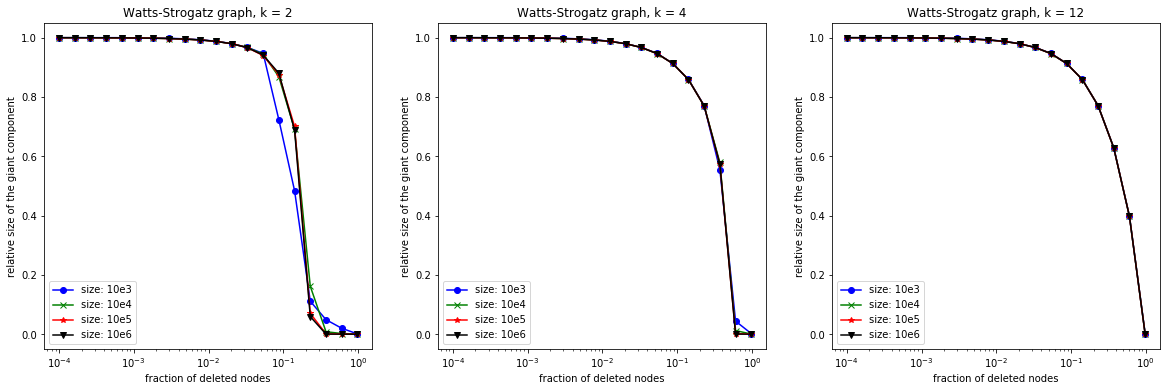

In [0]:
fraction_list = np.logspace(-4, -0.01, 20)
sizes = np.array([10e2, 10e3, 10e4, 10e5],dtype=np.int32)
k_list = [2, 4, 12]

Pfs, P0s = generate_and_examine(fraction_list, sizes, k_list, 'WS', beta=0.01, verbose = True)


create_plots(fraction_list, sizes, k_list, Pfs, P0s, 'WS', task='random')


## Random graph

'k: 12, N: 1000000, f: 0.9772372209558107'

'Stage 1'

334.4446105957031

'Stage 2'

334.96540927886963

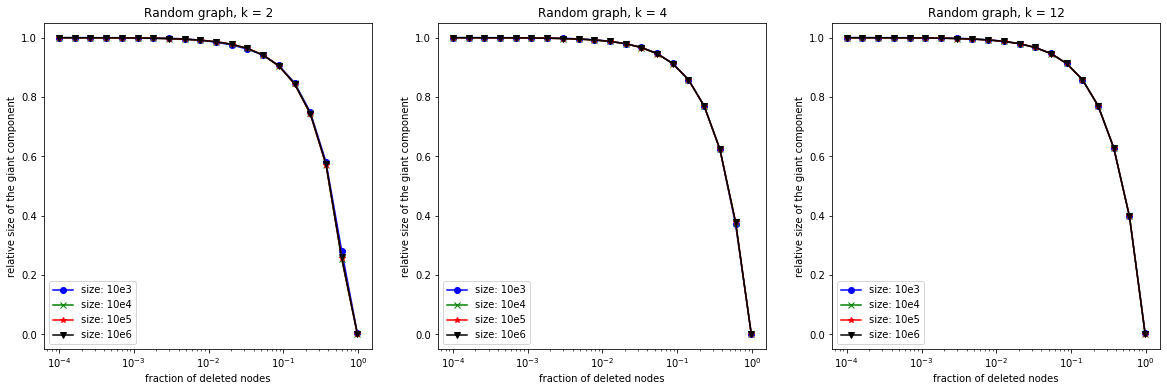

In [0]:
fraction_list = np.logspace(-4, -0.01, 20)
sizes = np.array([10e2, 10e3, 10e4, 10e5],dtype=np.int32)
k_list = [2, 4, 12]

Pfs, P0s = generate_and_examine(fraction_list, sizes, k_list, 'G', verbose=True, load_from_file=True)
create_plots(fraction_list, sizes, k_list, Pfs, P0s, 'G', task='random')

## Barabasi-Albert graph

'k: 12, N: 1000000, f: 0.9772372209558107'

'Stage 1'

182.6531205177307

'Stage 2'

183.22534108161926

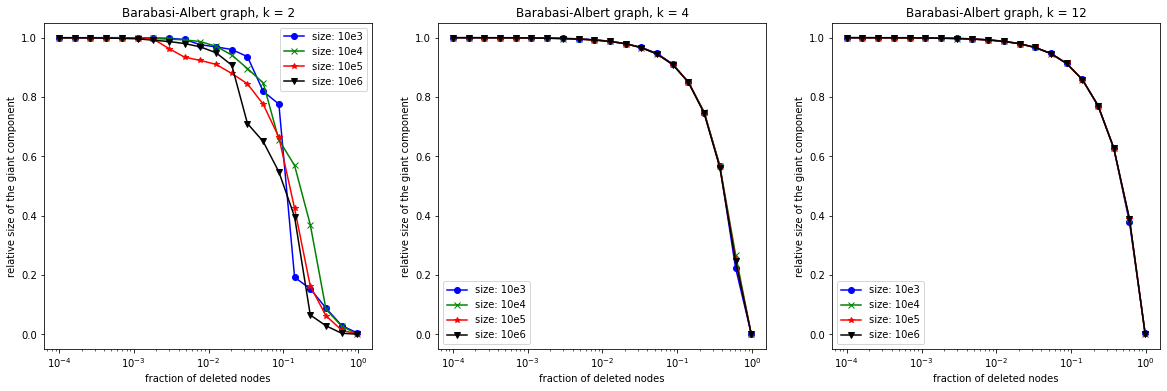

In [0]:
fraction_list = np.logspace(-4, -0.01, 20)
sizes = np.array([10e2, 10e3, 10e4, 10e5],dtype=np.int32)
k_list = [2, 4, 12]

Pfs, P0s = generate_and_examine(fraction_list, sizes, k_list, 'BA', verbose=True)
create_plots(fraction_list, sizes, k_list, Pfs, P0s, 'BA', task='random')

# Task 2

## Watts-Strogatz graph

'k: 12, N: 1000000, f: 0.9772372209558107'

'Stage 1'

101.32367444038391

'Stage 2'

101.70882034301758

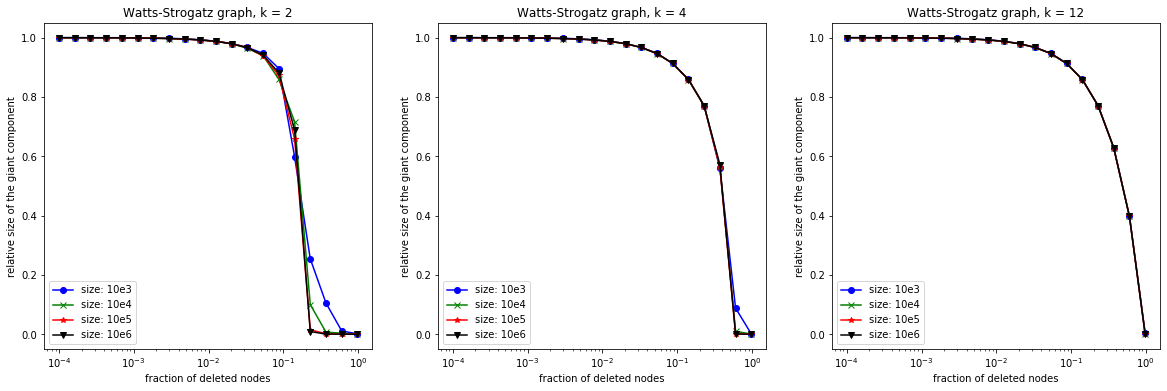

In [0]:
fraction_list = np.logspace(-4, -0.01, 20)
sizes = np.array([10e2, 10e3, 10e4, 10e5],dtype=np.int32)
k_list = [2, 4, 12]

Pfs, P0s = generate_and_examine(fraction_list, sizes, k_list, 'WS', beta=0.01, verbose=True)


create_plots(fraction_list, sizes, k_list, Pfs, P0s, 'WS', task='attack')


## Random graph

'k: 12, N: 1000000, f: 0.9772372209558107'

'Stage 1'

295.74262595176697

'Stage 2'

296.19953894615173

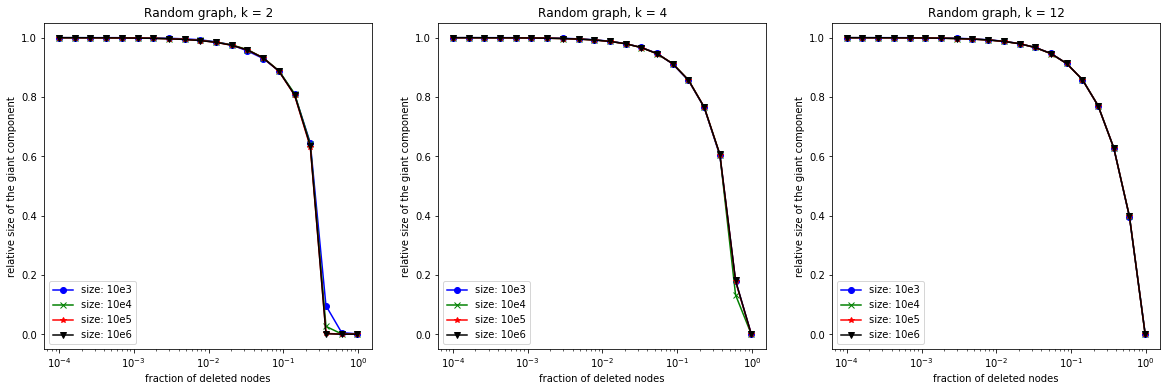

In [0]:
fraction_list = np.logspace(-4, -0.01, 20)
sizes = np.array([10e2, 10e3, 10e4, 10e5],dtype=np.int32)
k_list = [2, 4, 12]

Pfs, P0s = generate_and_examine(fraction_list, sizes, k_list, 'G', high_to_low=True, verbose=True, load_from_file=True)
create_plots(fraction_list, sizes, k_list, Pfs, P0s, 'G', task='attack')

## Barabasi-Albert graph

'k: 12, N: 1000000, f: 0.9772372209558107'

'Stage 1'

154.5137960910797

'Stage 2'

154.94966745376587

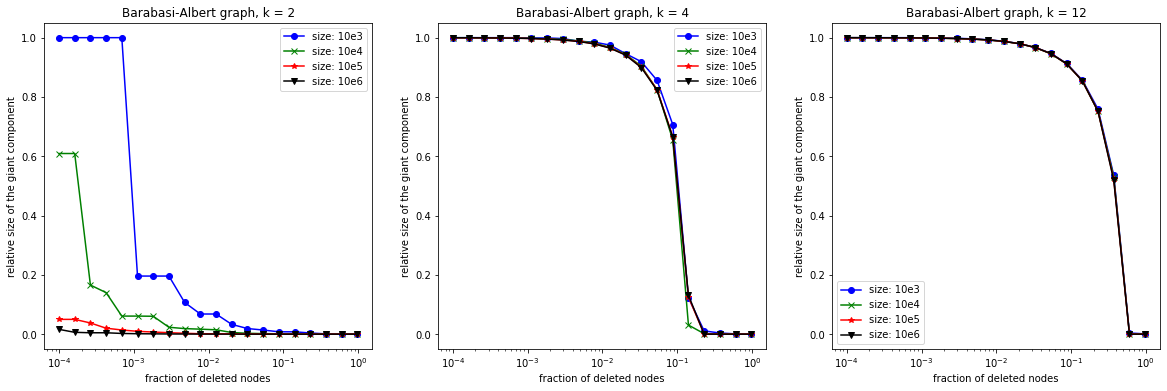

In [0]:
fraction_list = np.logspace(-4, -0.01, 20)
sizes = np.array([10e2, 10e3, 10e4, 10e5],dtype=np.int32)
k_list = [2, 4, 12]

Pfs, P0s = generate_and_examine(fraction_list, sizes, k_list, 'BA', high_to_low=True, verbose=True)
create_plots(fraction_list, sizes, k_list, Pfs, P0s, 'BA', task='attack')


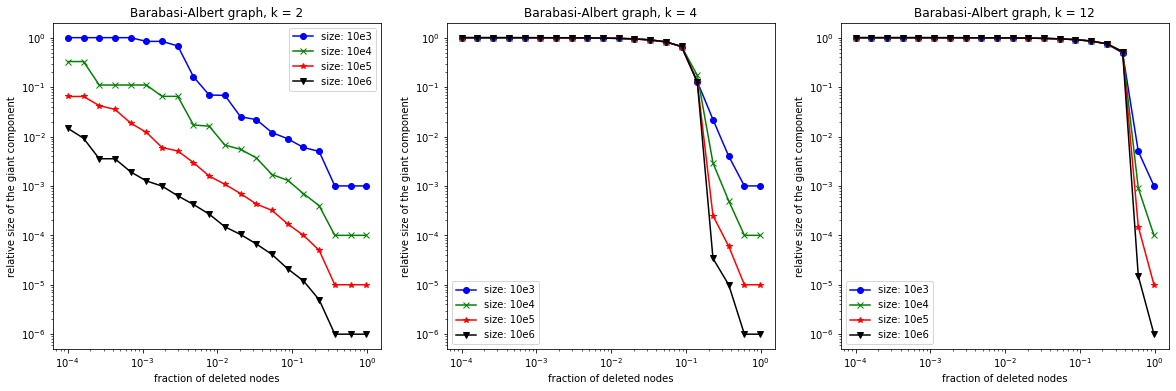

In [0]:
create_plots(fraction_list, sizes, k_list, Pfs, P0s, 'BA', task='attack', yscale='log')